In [1]:
import pandas as pd
import pyodbc
import pandasql as psql
import numpy as np

In [2]:
con = pyodbc.connect('DRIVER={Oracle en ODAC1025_64};DBQ=QISCTOS.world;UID=CGARCIA;PWD=Cg4rc16_2024')

In [12]:

prestaciones_foco = pd.read_csv("C:/Users/cgarciaa/Desktop/Prestaciones foco ambulatorias.csv", sep=';', encoding='latin-1')
lista_prestaciones = prestaciones_foco['Prestacion'].unique().tolist()
intervalos_dias = [15, 30, 45, 60, 75, 90]
resultados_df = pd.DataFrame(columns=['Intervalo_dias', 'Num_RUT_Unicos', 'Num_RUT_Unicos_Prestaciones', 'Tasa_Examenes'])

for dias in intervalos_dias:
    query = f"""
    WITH primera_consulta AS (
        SELECT
            AL2.RUT_BENEFICIARIO,
            AL1.PRISA_CODIGO AS PRESTACION_TRAUMATOLOGICA,
            MAX(AL2.FECHA_HORA_EMISION) AS FECHA_PRIMERA_ATENCION,
            AL2.TIPO_DOCUMENTO
        FROM
            BENEFICIOS.BEN_LINEAS_LIQUIDACIONES AL1
        INNER JOIN
            BENEFICIOS.BEN_DOCUMENTOS_LIQUIDACIONES AL2
                ON AL1.DOLI_CORRELATIVO = AL2.CORRELATIVO
        WHERE
            (AL1.PRISA_CODIGO = 101310 OR AL1.PRISA_CODIGO = 101872 OR AL1.PRISA_CODIGO = 108310)
            AND AL2.FECHA_HORA_EMISION >= TO_DATE('2024-07-01', 'YYYY-MM-DD')
            AND AL2.FECHA_HORA_EMISION < TO_DATE('2024-08-01', 'YYYY-MM-DD')
        GROUP BY
            AL2.RUT_BENEFICIARIO,
            AL2.TIPO_DOCUMENTO,
            AL1.PRISA_CODIGO
    ),
    consulta_previa AS (
        SELECT
            AL2.RUT_BENEFICIARIO,
            AL2.FECHA_HORA_EMISION AS FECHA_CONSULTA_PREVIA
        FROM
            BENEFICIOS.BEN_LINEAS_LIQUIDACIONES AL1
        INNER JOIN
            BENEFICIOS.BEN_DOCUMENTOS_LIQUIDACIONES AL2
                ON AL1.DOLI_CORRELATIVO = AL2.CORRELATIVO
        WHERE
            (AL1.PRISA_CODIGO = 101301 OR AL1.PRISA_CODIGO = 101872 OR AL1.PRISA_CODIGO = 108310)
    ),
    base_beneficiarios AS (
        SELECT
            pc.RUT_BENEFICIARIO,
            pc.FECHA_PRIMERA_ATENCION,
            CASE WHEN COUNT(cp.RUT_BENEFICIARIO) > 0 THEN 0 ELSE 1 END AS TUVO_CONSULTA_PREVIA,
            pc.TIPO_DOCUMENTO,
            pc.PRESTACION_TRAUMATOLOGICA
        FROM
            primera_consulta pc
        LEFT JOIN consulta_previa cp
            ON pc.RUT_BENEFICIARIO = cp.RUT_BENEFICIARIO
            AND cp.FECHA_CONSULTA_PREVIA >= pc.FECHA_PRIMERA_ATENCION - INTERVAL '{dias}' DAY
            AND cp.FECHA_CONSULTA_PREVIA < pc.FECHA_PRIMERA_ATENCION
        GROUP BY
            pc.RUT_BENEFICIARIO,
            pc.FECHA_PRIMERA_ATENCION,
            pc.TIPO_DOCUMENTO,
            pc.PRESTACION_TRAUMATOLOGICA
        HAVING
            CASE WHEN COUNT(cp.RUT_BENEFICIARIO) > 0 THEN 0 ELSE 1 END = 0
    )
    SELECT
        bb.RUT_BENEFICIARIO,
        bb.PRESTACION_TRAUMATOLOGICA,
        bb.FECHA_PRIMERA_ATENCION,
        p.PRESTACION,
        p.FECHA_HORA_EMISION AS FECHA_PRESTACION,
        bb.TIPO_DOCUMENTO
    FROM
        base_beneficiarios bb
    LEFT JOIN (
        SELECT
            AL2.RUT_BENEFICIARIO,
            AL1.PRISA_CODIGO AS PRESTACION,
            AL2.FECHA_HORA_EMISION
        FROM
            BENEFICIOS.BEN_LINEAS_LIQUIDACIONES AL1
        INNER JOIN
            BENEFICIOS.BEN_DOCUMENTOS_LIQUIDACIONES AL2
                ON AL1.DOLI_CORRELATIVO = AL2.CORRELATIVO
        WHERE
            AL2.FECHA_HORA_EMISION > (SELECT MAX(FECHA_PRIMERA_ATENCION) FROM primera_consulta WHERE RUT_BENEFICIARIO = AL2.RUT_BENEFICIARIO)
    ) p
        ON bb.RUT_BENEFICIARIO = p.RUT_BENEFICIARIO
    ORDER BY 
        bb.RUT_BENEFICIARIO DESC 
    """
    personas_consulta_trauma = pd.read_sql(query, con)
    personas_consulta_trauma = personas_consulta_trauma[personas_consulta_trauma['TIPO_DOCUMENTO'].isna()]
    prestaciones_foco = pd.read_csv("C:/Users/cgarciaa/Desktop/Prestaciones foco ambulatorias.csv", sep=';', encoding='latin-1')
    num_rut_unicos = personas_consulta_trauma['RUT_BENEFICIARIO'].nunique()
    personas_consulta = personas_consulta_trauma[personas_consulta_trauma['PRESTACION'].isin(lista_prestaciones)]
    num_rut_unicos_2 = personas_consulta['RUT_BENEFICIARIO'].nunique()
    tasa_examenes = num_rut_unicos_2 / num_rut_unicos if num_rut_unicos > 0 else 0
    
    nuevos_resultados = pd.DataFrame({
        'Intervalo_dias': [dias],
        'Num_RUT_Unicos': [num_rut_unicos],
        'Num_RUT_Unicos_Prestaciones': [num_rut_unicos_2],
        'Tasa_Examenes': [tasa_examenes]
    })
    
    resultados_df = pd.concat([resultados_df, nuevos_resultados], ignore_index=True)

resultados_df


C:\Users\cgarciaa\AppData\Local\Temp\ipykernel_23680\1922521772.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  personas_consulta_trauma = pd.read_sql(query, con)
C:\Users\cgarciaa\AppData\Local\Temp\ipykernel_23680\1922521772.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultados_df = pd.concat([resultados_df, nuevos_resultados], ignore_index=True)
C:\Users\cgarciaa\AppData\Local\Temp\ipykernel_23680\1922521772.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are 

,Intervalo_dias,Num_RUT_Unicos,Num_RUT_Unicos_Prestaciones,Tasa_Examenes
0,15,157,76,0.484076
1,30,273,146,0.534799
2,45,376,196,0.521277
3,60,490,256,0.522449
4,75,598,321,0.536789
5,90,719,392,0.545202


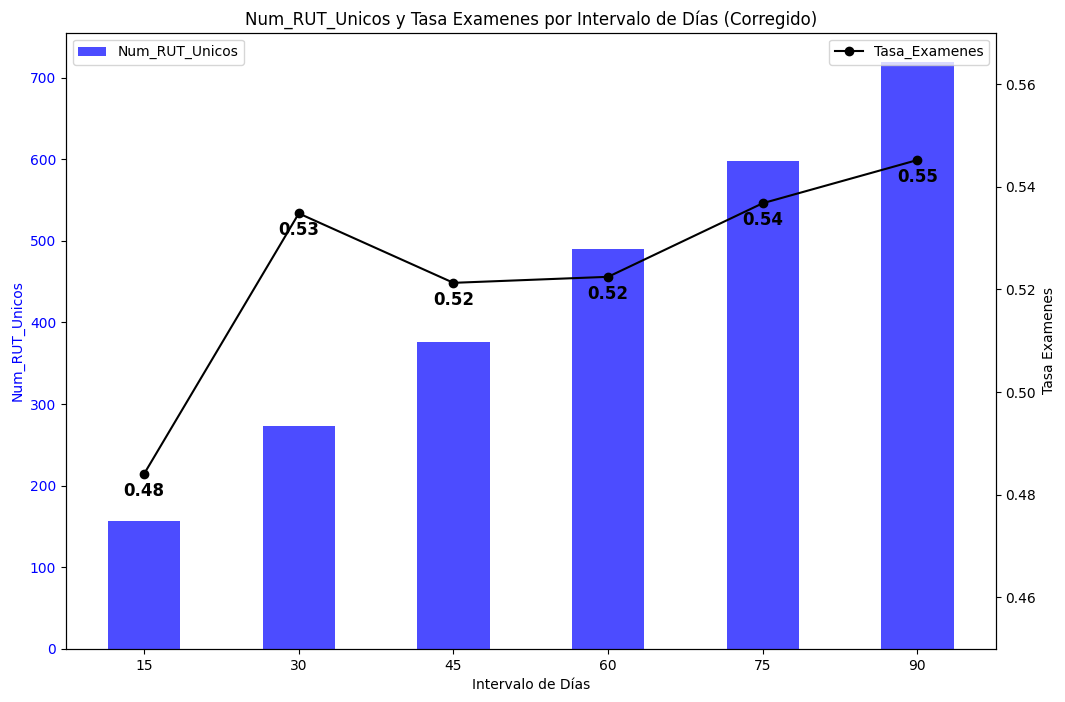

In [23]:
# Crear figura y eje con un tamaño más grande, cambiando el color de la línea de rojo a negro
fig, ax1 = plt.subplots(figsize=(12, 8))

# Crear el gráfico de barras para Num_RUT_Unicos con barras más anchas
ax1.bar(dias_reales, num_rut_unicos, color='b', alpha=0.7, width=7, label='Num_RUT_Unicos')
ax1.set_xlabel('Intervalo de Días')
ax1.set_ylabel('Num_RUT_Unicos', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Ajustamos los ticks del eje X para que correspondan a los valores de 15, 30, 45, etc.
ax1.set_xticks(dias_reales)

# Crear un segundo eje para la tasa de exámenes con color negro
ax2 = ax1.twinx()
ax2.plot(dias_reales, tasa_examenes, color='k', marker='o', label='Tasa_Examenes')  # Cambiamos a negro ('k')

# Ajustar para que los valores de la tasa de exámenes no se superpongan
for i, valor in enumerate(tasa_examenes):
    ax2.text(dias_reales[i], tasa_examenes[i] - 0.005, f'{valor:.2f}', ha='center', va='bottom', color='k', fontsize=12, fontweight='bold')

# Configurar el eje secundario para que no se salga del margen
ax2.set_ylim(0.45, 0.57)

# Eliminar las líneas internas del gráfico
ax1.grid(False)

ax2.set_ylabel('Tasa Examenes', color='k')  # Cambiamos la etiqueta a negro también
ax2.tick_params(axis='y', labelcolor='k')

# Título y leyendas
plt.title('Num_RUT_Unicos y Tasa Examenes por Intervalo de Días (Corregido)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar el gráfico
plt.show()




In [5]:
import pandas as pd

# Definir la variable 'dias' para el intervalo de días
dias = 60  # Puedes cambiar este valor para probar diferentes intervalos

# Definir la consulta SQL
query = f"""
WITH primera_consulta AS (
    SELECT DISTINCT
        AL2.RUT_BENEFICIARIO,
        AL1.PRISA_CODIGO AS PRESTACION_TRAUMATOLOGICA,
        MAX(AL2.FECHA_HORA_EMISION) AS FECHA_PRIMERA_ATENCION,
        AL2.TIPO_DOCUMENTO
    FROM
        BENEFICIOS.BEN_LINEAS_LIQUIDACIONES AL1
    INNER JOIN
        BENEFICIOS.BEN_DOCUMENTOS_LIQUIDACIONES AL2
            ON AL1.DOLI_CORRELATIVO = AL2.CORRELATIVO
    WHERE
        (AL1.PRISA_CODIGO = 101310 OR AL1.PRISA_CODIGO = 101872 OR AL1.PRISA_CODIGO = 108310)
        AND AL2.FECHA_HORA_EMISION >= TO_DATE('2024-07-01', 'YYYY-MM-DD')
        AND AL2.FECHA_HORA_EMISION < TO_DATE('2024-08-01', 'YYYY-MM-DD')
    GROUP BY
        AL2.RUT_BENEFICIARIO,
        AL2.TIPO_DOCUMENTO,
        AL1.PRISA_CODIGO
),
consulta_previa AS (
    SELECT DISTINCT
        AL2.RUT_BENEFICIARIO,
        AL2.FECHA_HORA_EMISION AS FECHA_CONSULTA_PREVIA
    FROM
        BENEFICIOS.BEN_LINEAS_LIQUIDACIONES AL1
    INNER JOIN
        BENEFICIOS.BEN_DOCUMENTOS_LIQUIDACIONES AL2
            ON AL1.DOLI_CORRELATIVO = AL2.CORRELATIVO
    WHERE
        (AL1.PRISA_CODIGO = 101301 OR AL1.PRISA_CODIGO = 101872 OR AL1.PRISA_CODIGO = 108310)
),
base_beneficiarios AS (
    SELECT DISTINCT
        pc.RUT_BENEFICIARIO,
        pc.FECHA_PRIMERA_ATENCION,
        CASE WHEN COUNT(cp.RUT_BENEFICIARIO) > 0 THEN 0 ELSE 1 END AS TUVO_CONSULTA_PREVIA,
        pc.TIPO_DOCUMENTO,
        pc.PRESTACION_TRAUMATOLOGICA
    FROM
        primera_consulta pc
    LEFT JOIN consulta_previa cp
        ON pc.RUT_BENEFICIARIO = cp.RUT_BENEFICIARIO
        AND cp.FECHA_CONSULTA_PREVIA >= pc.FECHA_PRIMERA_ATENCION - INTERVAL '{dias}' DAY
        AND cp.FECHA_CONSULTA_PREVIA < pc.FECHA_PRIMERA_ATENCION
    GROUP BY
        pc.RUT_BENEFICIARIO,
        pc.FECHA_PRIMERA_ATENCION,
        pc.TIPO_DOCUMENTO,
        pc.PRESTACION_TRAUMATOLOGICA
    HAVING
        CASE WHEN COUNT(cp.RUT_BENEFICIARIO) > 0 THEN 0 ELSE 1 END = 0
)
SELECT
    bb.RUT_BENEFICIARIO,
    bb.PRESTACION_TRAUMATOLOGICA,
    bb.FECHA_PRIMERA_ATENCION,
    p.PRESTACION,
    p.FECHA_HORA_EMISION AS FECHA_PRESTACION,
    bb.TIPO_DOCUMENTO
FROM
    base_beneficiarios bb
LEFT JOIN (
    SELECT DISTINCT
        AL2.RUT_BENEFICIARIO,
        AL1.PRISA_CODIGO AS PRESTACION,
        AL2.FECHA_HORA_EMISION
    FROM
        BENEFICIOS.BEN_LINEAS_LIQUIDACIONES AL1
    INNER JOIN
        BENEFICIOS.BEN_DOCUMENTOS_LIQUIDACIONES AL2
            ON AL1.DOLI_CORRELATIVO = AL2.CORRELATIVO
    WHERE
        AL2.FECHA_HORA_EMISION > (SELECT MAX(FECHA_PRIMERA_ATENCION) FROM primera_consulta WHERE RUT_BENEFICIARIO = AL2.RUT_BENEFICIARIO)
) p
    ON bb.RUT_BENEFICIARIO = p.RUT_BENEFICIARIO
ORDER BY 
    bb.RUT_BENEFICIARIO DESC

"""

# Ejecutar la consulta en la base de datos usando pandas
personas_consulta_trauma = pd.read_sql(query, con)

# Verificar los primeros resultados
print(personas_consulta_trauma.head())


C:\Users\cgarciaa\AppData\Local\Temp\ipykernel_27372\2512061496.py:90: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  personas_consulta_trauma = pd.read_sql(query, con)


   RUT_BENEFICIARIO  PRESTACION_TRAUMATOLOGICA FECHA_PRIMERA_ATENCION  \
0        28305290.0                   101310.0    2024-07-31 16:08:04   
1        28305290.0                   101310.0    2024-07-31 16:08:04   
2        28305290.0                   101310.0    2024-07-31 16:08:04   
3        28305290.0                   101310.0    2024-07-31 16:08:04   
4        28305290.0                   101310.0    2024-07-31 16:08:04   

   PRESTACION    FECHA_PRESTACION TIPO_DOCUMENTO  
0    301067.0 2024-08-21 22:26:43           None  
1    601104.0 2024-08-21 22:26:40           None  
2    101201.0 2024-08-14 10:12:19           None  
3   1701020.0 2024-08-02 22:06:03           None  
4    201202.0 2024-08-02 22:06:02           None  


In [4]:
personas_consulta_trauma

,RUT_BENEFICIARIO,PRESTACION_TRAUMATOLOGICA,FECHA_PRIMERA_ATENCION,PRESTACION,FECHA_PRESTACION,TIPO_DOCUMENTO
0,28305290.0,101310.0,2024-07-31 16:08:04,301067.0,2024-08-21 22:26:43,None
1,28305290.0,101310.0,2024-07-31 16:08:04,601104.0,2024-08-21 22:26:40,None
2,28305290.0,101310.0,2024-07-31 16:08:04,101201.0,2024-08-14 10:12:19,None
3,28305290.0,101310.0,2024-07-31 16:08:04,1701020.0,2024-08-02 22:06:03,None
4,28305290.0,101310.0,2024-07-31 16:08:04,201202.0,2024-08-02 22:06:02,None
...,...,...,...,...,...,...
4376,2673235.0,101310.0,2024-07-12 13:25:53,101301.0,2024-08-20 15:59:15,None
4377,2673235.0,101310.0,2024-07-12 13:25:53,101001.0,2024-07-18 16:32:47,None
4378,2673235.0,101310.0,2024-07-12 13:25:53,101311.0,2024-09-03 15:54:28,None
4379,2673235.0,101310.0,2024-07-12 13:25:53,401051.0,2024-07-12 13:57:56,None


## dede aqui

In [3]:
primera_consulta_trauma= pd.read_sql("""
SELECT DISTINCT
    AL2.RUT_BENEFICIARIO,
    AL1.PRISA_CODIGO AS PRESTACION_TRAUMATOLOGICA,
    MAX(AL2.FECHA_HORA_EMISION) AS FECHA_PRIMERA_ATENCION,
    AL2.TIPO_DOCUMENTO
FROM
    BENEFICIOS.BEN_LINEAS_LIQUIDACIONES AL1
INNER JOIN
    BENEFICIOS.BEN_DOCUMENTOS_LIQUIDACIONES AL2
        ON AL1.DOLI_CORRELATIVO = AL2.CORRELATIVO
WHERE
    (AL1.PRISA_CODIGO = 101310 OR AL1.PRISA_CODIGO = 101872 OR AL1.PRISA_CODIGO = 108310)
    AND AL2.FECHA_HORA_EMISION >= TO_DATE('2024-07-01', 'YYYY-MM-DD')
    AND AL2.FECHA_HORA_EMISION < TO_DATE('2024-08-01', 'YYYY-MM-DD')
    AND AL2.TIPO_DOCUMENTO IS NULL
GROUP BY
    AL2.RUT_BENEFICIARIO,
    AL2.TIPO_DOCUMENTO,
    AL1.PRISA_CODIGO;
""", con)

C:\Users\cgarciaa\AppData\Local\Temp\ipykernel_2180\4052362443.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  primera_consulta_trauma= pd.read_sql("""


In [4]:
primera_consulta_trauma = primera_consulta_trauma.drop_duplicates(subset=['RUT_BENEFICIARIO'])

In [5]:
num_rut_unicos = primera_consulta_trauma['RUT_BENEFICIARIO'].nunique()
num_rut_unicos

15627

In [6]:
consulta_previa_trauma=pd.read_sql("""       
        SELECT
            AL2.RUT_BENEFICIARIO,
            AL2.FECHA_HORA_EMISION AS FECHA_CONSULTA_PREVIA
        FROM
            BENEFICIOS.BEN_LINEAS_LIQUIDACIONES AL1
        INNER JOIN
            BENEFICIOS.BEN_DOCUMENTOS_LIQUIDACIONES AL2
                ON AL1.DOLI_CORRELATIVO = AL2.CORRELATIVO
        WHERE
            (AL1.PRISA_CODIGO = 101301 OR AL1.PRISA_CODIGO = 101872 OR AL1.PRISA_CODIGO = 108310)
""", con)

C:\Users\cgarciaa\AppData\Local\Temp\ipykernel_2180\2200735537.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  consulta_previa_trauma=pd.read_sql("""


In [7]:
primera_consulta_trauma['FECHA_PRIMERA_ATENCION'] = pd.to_datetime(primera_consulta_trauma['FECHA_PRIMERA_ATENCION'])
consulta_previa_trauma['FECHA_CONSULTA_PREVIA'] = pd.to_datetime(consulta_previa_trauma['FECHA_CONSULTA_PREVIA'])

# Crear una nueva columna para almacenar el resultado
primera_consulta_trauma['TIENE_CONSULTA_PREVIA'] = 0

# Definir los días de rango (30 o 60)
dias_rango = 30  # Puedes cambiar esto a 30 si lo deseas

# Iterar por cada fila en primera_consulta_trauma
for idx, row in primera_consulta_trauma.iterrows():
    rut = row['RUT_BENEFICIARIO']
    fecha_consulta = row['FECHA_PRIMERA_ATENCION']
    
    # Restar los días a la fecha de la primera atención
    fecha_inicio_rango = fecha_consulta - pd.Timedelta(days=dias_rango)
    
    # Verificar si existe alguna consulta previa en el rango de días para el mismo RUT
    consultas_previas = consulta_previa_trauma[
        (consulta_previa_trauma['RUT_BENEFICIARIO'] == rut) &
        (consulta_previa_trauma['FECHA_CONSULTA_PREVIA'] >= fecha_inicio_rango) &
        (consulta_previa_trauma['FECHA_CONSULTA_PREVIA'] < fecha_consulta)
    ]
    
    # Si se encuentra al menos una consulta en el rango, asignar 1
    if not consultas_previas.empty:
        primera_consulta_trauma.at[idx, 'TIENE_CONSULTA_PREVIA'] = 1


In [10]:
num_rut_unicos = primera_consulta_trauma['RUT_BENEFICIARIO'].nunique()
num_rut_unicos

15627

In [11]:
primera_consulta_trauma = primera_consulta_trauma[primera_consulta_trauma['TIENE_CONSULTA_PREVIA'] == 0]

In [12]:
num_rut_unicos_2 = primera_consulta_trauma['RUT_BENEFICIARIO'].nunique()
num_rut_unicos_2

15356

In [13]:
prestaciones_posterior=pd.read_sql("""       
        SELECT
            AL2.RUT_BENEFICIARIO,
            AL2.FECHA_HORA_EMISION AS FECHA_CONSULTA_PREVIA,
            AL1.PRISA_CODIGO AS PRESTACION_POSTERIOR
        FROM
            BENEFICIOS.BEN_LINEAS_LIQUIDACIONES AL1
        INNER JOIN
            BENEFICIOS.BEN_DOCUMENTOS_LIQUIDACIONES AL2
                ON AL1.DOLI_CORRELATIVO = AL2.CORRELATIVO
        WHERE 
           AL2.FECHA_HORA_EMISION >= TO_DATE('2024-07-01', 'YYYY-MM-DD')    
""", con)

C:\Users\cgarciaa\AppData\Local\Temp\ipykernel_15656\3083393282.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  prestaciones_posterior=pd.read_sql("""


In [14]:
prestaciones_a_excluir = [101301, 101872, 108310]
prestaciones_posteriores = prestaciones_posterior[~prestaciones_posterior['PRESTACION_POSTERIOR'].isin(prestaciones_a_excluir)]

In [15]:
prestaciones_posteriores=psql.sqldf("""
    SELECT 
        a.*,
        b.PRESTACION_POSTERIOR,
        b.FECHA_CONSULTA_PREVIA
    FROM 
        primera_consulta_trauma a
    LEFT JOIN 
        prestaciones_posteriores b
    ON 
        a.RUT_BENEFICIARIO=b.RUT_BENEFICIARIO
    WHERE 
        a.FECHA_PRIMERA_ATENCION<b.FECHA_CONSULTA_PREVIA
    """)

In [16]:
prestaciones_foco = pd.read_csv("C:/Users/cgarciaa/Desktop/Prestaciones foco ambulatorias.csv", sep=';', encoding='latin-1')
lista_prestaciones = prestaciones_foco['Prestacion'].unique().tolist()

In [17]:
prestaciones_foco

,Prestacion,Glosa,Clasificación Ambulatoria Presupuesto,Grupo de Prestaciones,Sub Grupo Prestaciones,Clasificación Orientación,Foco,foco en el tableau,Orientable
0,401001,"Radiografía de las glándulas salivales ""sialog...",Imágenes,IMÁGENES,09_Rayos,Rayos,Si,Si,Si
1,401002,"Radiografía de partes blandas, laringe lateral...",Imágenes,IMÁGENES,09_Rayos,Rayos,Si,Si,Si
2,401003,PLANIGRAFIAS LARINGE (4 EXP),Imágenes,IMÁGENES,09_Rayos,Rayos,Si,Si,Si
3,401004,"Radiografía de tórax, proyección complementari...",Imágenes,IMÁGENES,09_Rayos,Rayos,Si,Si,Si
4,401006,Estudio radiológico de corazón (incluye fluoro...,Imágenes,IMÁGENES,09_Rayos,Rayos,Si,Si,Si
...,...,...,...,...,...,...,...,...,...
174,496006,"R.N.M. CUELLO (LARINGE, CAROTIDAS, ETC.)",Imágenes,IMÁGENES,06_Resonancia,Resonancia,Si,Si,Si
175,496009,"R.N.M.ABDOMEN(HIGA.,PANCR.,BAZO, RINONES, AORT...",Imágenes,IMÁGENES,06_Resonancia,Resonancia,Si,Si,Si
176,496010,"R.N.M. PELVIS (UTERO,OVARIOS,TROMPAS,VEJI.O PR...",Imágenes,IMÁGENES,06_Resonancia,Resonancia,Si,Si,Si
177,496011,"R.N.M. RODILLA,CODO,MUNECA,CADE.,TOBI., UNI O ...",Imágenes,IMÁGENES,06_Resonancia,Resonancia,Si,Si,Si


In [18]:
prestaciones_totales = prestaciones_posteriores[prestaciones_posteriores['PRESTACION_POSTERIOR'].isin(lista_prestaciones)]

In [21]:
prestaciones_foco

,Prestacion,Glosa,Clasificación Ambulatoria Presupuesto,Grupo de Prestaciones,Sub Grupo Prestaciones,Clasificación Orientación,Foco,foco en el tableau,Orientable
0,401001,"Radiografía de las glándulas salivales ""sialog...",Imágenes,IMÁGENES,09_Rayos,Rayos,Si,Si,Si
1,401002,"Radiografía de partes blandas, laringe lateral...",Imágenes,IMÁGENES,09_Rayos,Rayos,Si,Si,Si
2,401003,PLANIGRAFIAS LARINGE (4 EXP),Imágenes,IMÁGENES,09_Rayos,Rayos,Si,Si,Si
3,401004,"Radiografía de tórax, proyección complementari...",Imágenes,IMÁGENES,09_Rayos,Rayos,Si,Si,Si
4,401006,Estudio radiológico de corazón (incluye fluoro...,Imágenes,IMÁGENES,09_Rayos,Rayos,Si,Si,Si
...,...,...,...,...,...,...,...,...,...
174,496006,"R.N.M. CUELLO (LARINGE, CAROTIDAS, ETC.)",Imágenes,IMÁGENES,06_Resonancia,Resonancia,Si,Si,Si
175,496009,"R.N.M.ABDOMEN(HIGA.,PANCR.,BAZO, RINONES, AORT...",Imágenes,IMÁGENES,06_Resonancia,Resonancia,Si,Si,Si
176,496010,"R.N.M. PELVIS (UTERO,OVARIOS,TROMPAS,VEJI.O PR...",Imágenes,IMÁGENES,06_Resonancia,Resonancia,Si,Si,Si
177,496011,"R.N.M. RODILLA,CODO,MUNECA,CADE.,TOBI., UNI O ...",Imágenes,IMÁGENES,06_Resonancia,Resonancia,Si,Si,Si


In [22]:
num_rut_unicos_2 = prestaciones_totales['RUT_BENEFICIARIO'].nunique()
num_rut_unicos_2

7679

In [23]:
data_final=psql.sqldf("""
    SELECT 
        a.*,
        b.Glosa
    FROM 
        prestaciones_totales a
    LEFT JOIN 
        prestaciones_foco b
    ON a.PRESTACION_POSTERIOR=b.Prestacion""")

In [24]:
data_final

,RUT_BENEFICIARIO,PRESTACION_TRAUMATOLOGICA,FECHA_PRIMERA_ATENCION,TIPO_DOCUMENTO,TIENE_CONSULTA_PREVIA,PRESTACION_POSTERIOR,FECHA_CONSULTA_PREVIA,Glosa
0,16143248.0,101310.0,2024-07-19 18:37:41.000000,None,0,404016.0,2024-07-29 13:24:28.000000,Ecografía Partes Blandas o Musculoesquelética ...
1,16143248.0,101310.0,2024-07-19 18:37:41.000000,None,0,404012.0,2024-08-05 17:01:48.000000,Ecografía mamaria bilateral (incluye Doppler)
2,16143248.0,101310.0,2024-07-19 18:37:41.000000,None,0,404016.0,2024-08-30 14:48:44.000000,Ecografía Partes Blandas o Musculoesquelética ...
3,28263101.0,101310.0,2024-07-24 14:10:48.000000,None,0,401022.0,2024-09-03 11:52:06.000000,Estudio radiológico de deglución faríngea
4,28263101.0,101310.0,2024-07-24 14:10:48.000000,None,0,401073.0,2024-09-12 16:12:58.000000,Videofluoroscopia para estudio de deglución
...,...,...,...,...,...,...,...,...
17056,16724785.0,108310.0,2024-07-19 08:31:53.000000,None,0,403019.0,2024-08-23 15:17:18.000000,Tomografía Computarizada de Columna Lumbar
17057,16724785.0,108310.0,2024-07-19 08:31:53.000000,None,0,401010.0,2024-08-24 08:50:23.000000,Mamografía bilateral
17058,16724785.0,108310.0,2024-07-19 08:31:53.000000,None,0,404012.0,2024-08-24 08:51:41.000000,Ecografía mamaria bilateral (incluye Doppler)
17059,10264712.0,108310.0,2024-07-08 17:03:02.000000,None,0,405007.0,2024-07-20 08:44:22.000000,Resonancia Magnética de columna lumbar


In [25]:
data_final.to_csv("C:/Users/cgarciaa/desktop/salidas_prestaciones_amb.csv", index=False)